In [115]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.signal import find_peaks

In [116]:
# load data
data = loadmat('data/heartbeat_data/001.mat')
sr = 360  # sampling rate for synthetic data
#print(data['val'].shape)  # shape (1, 4, 1500)
signal_data = data['val'][0]
print(signal_data.shape)

(4, 2365)


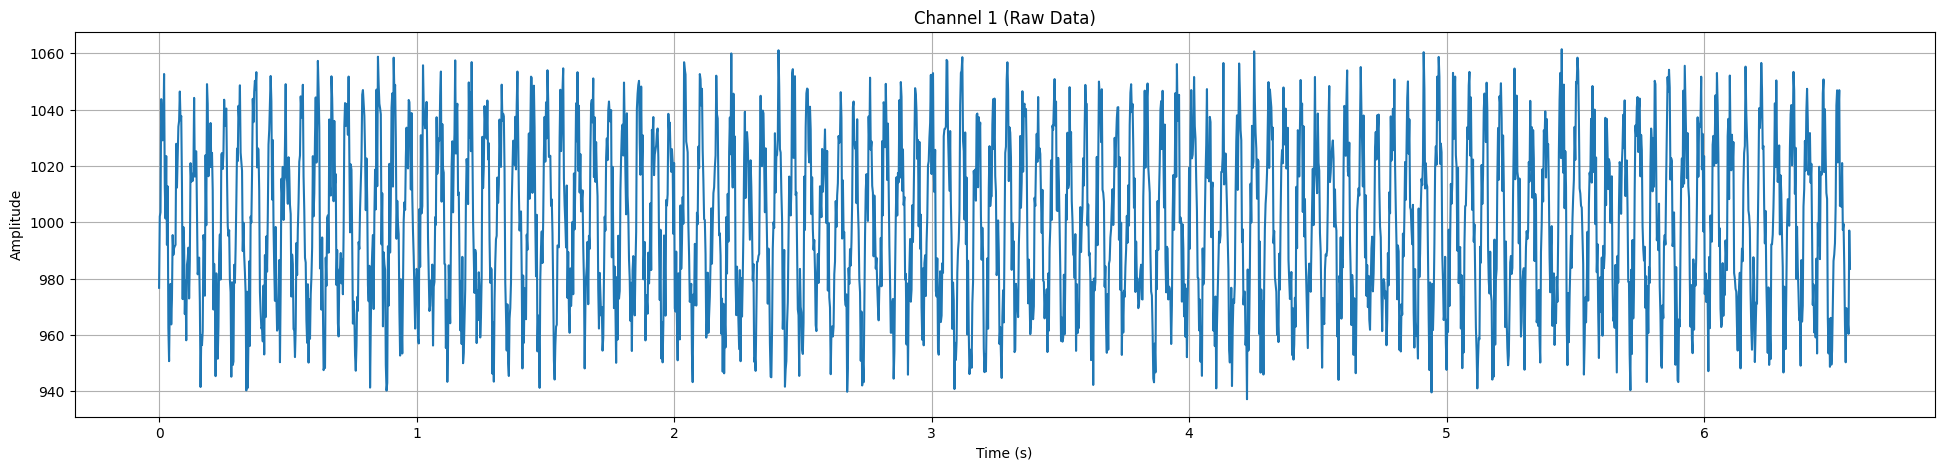

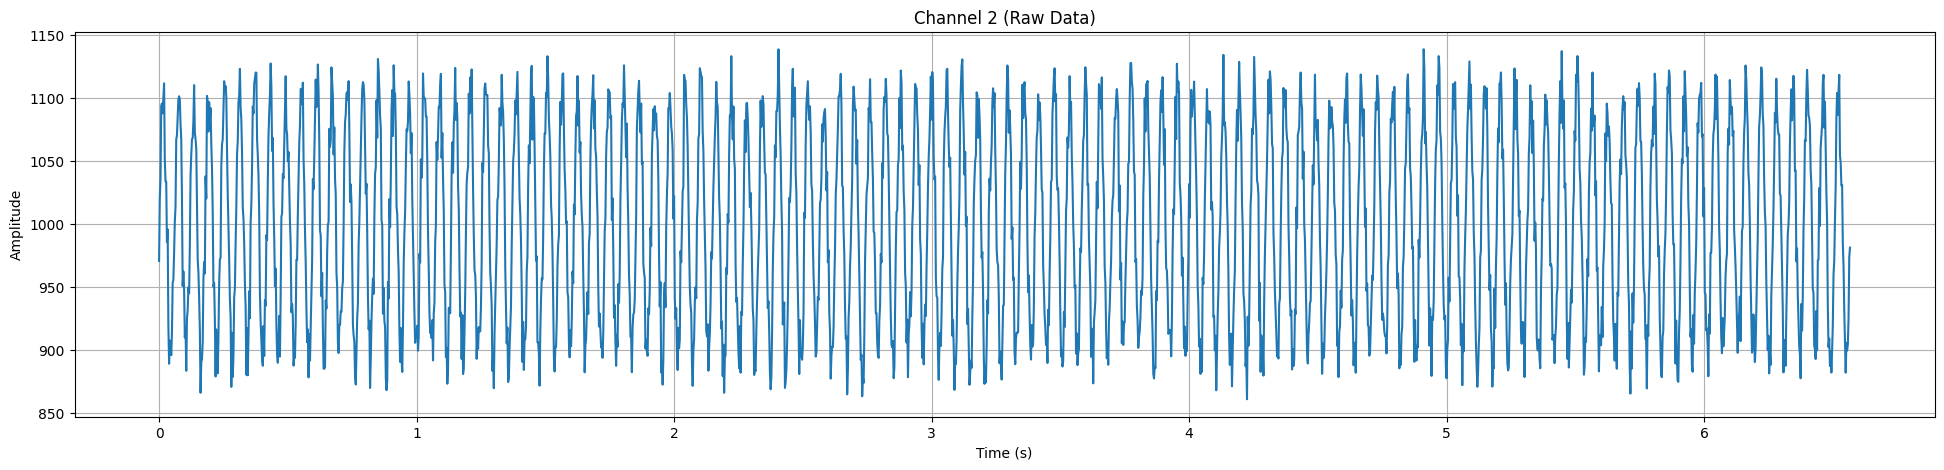

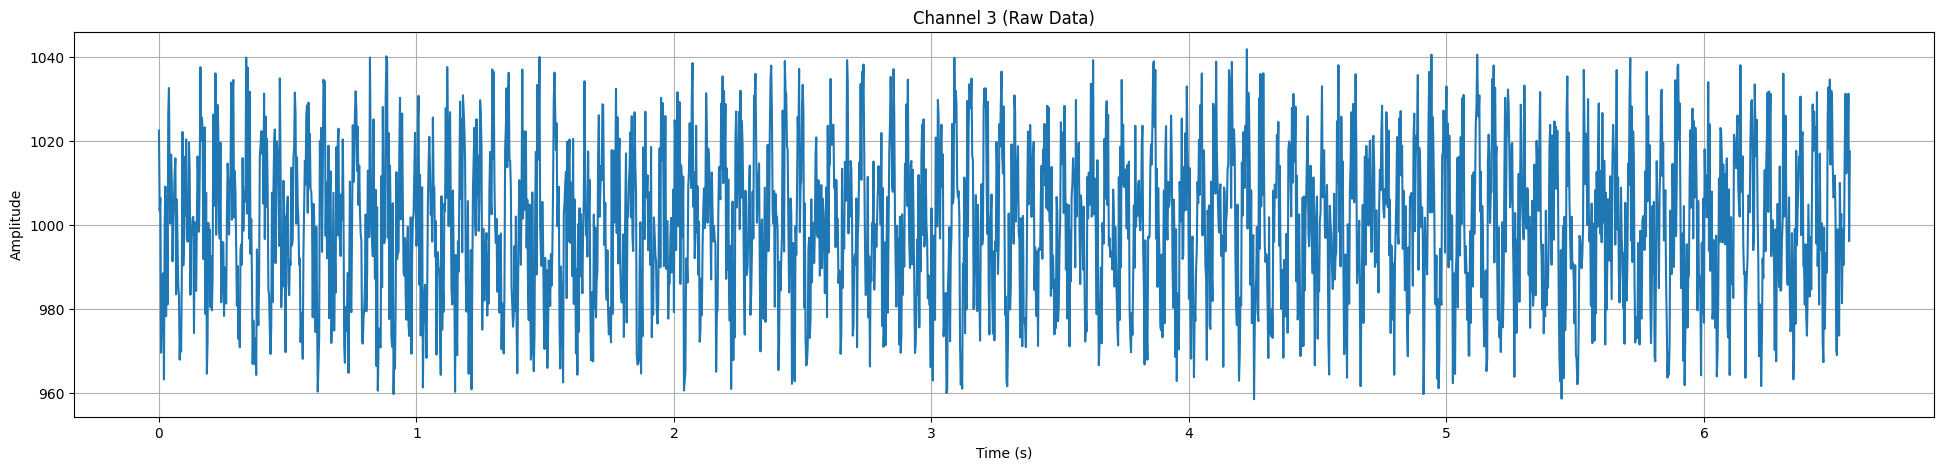

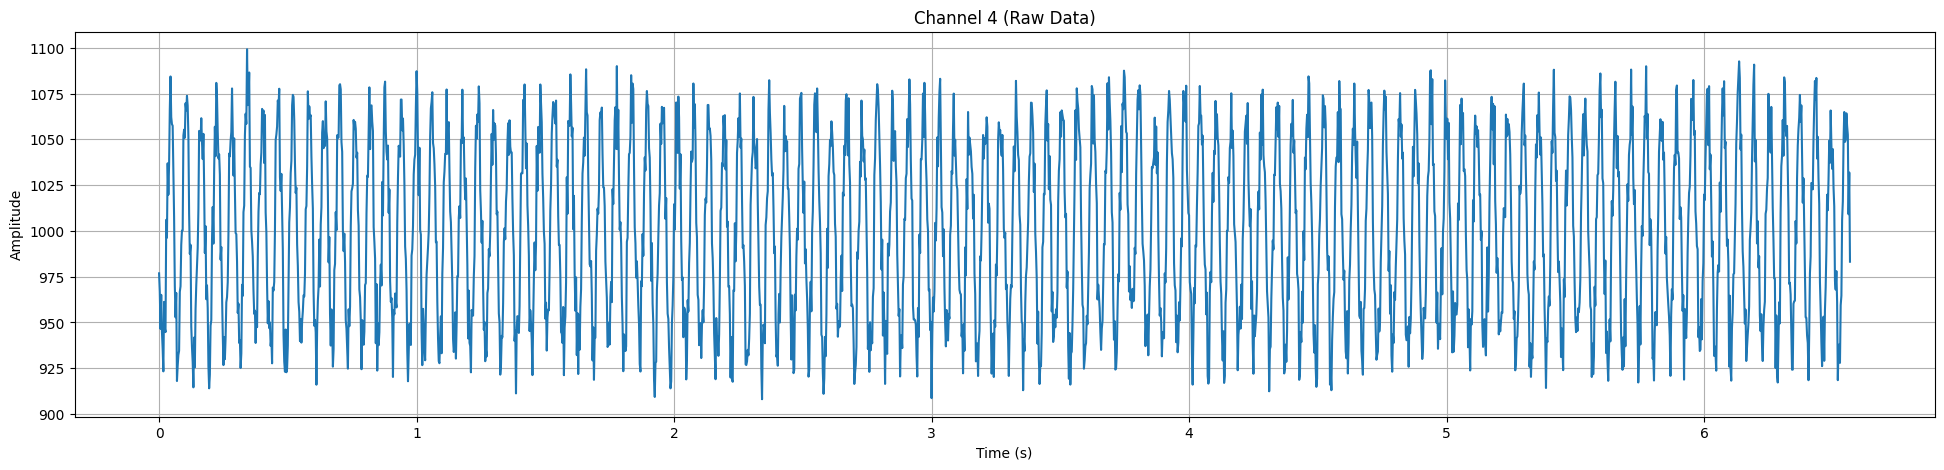

In [117]:
# plot the 4 recorded channels
for i in range(4):
    plt.figure(figsize=(24, 5))
    channel_data = signal_data[i]  # Extract raw data for each channel
    plt.plot(np.arange(0, len(channel_data) / sr, 1 / sr), channel_data)
    plt.title(f"Channel {i+1} (Raw Data)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
plt.show()

frequency analysis to determine if heartbeat is maternal/fetal
- fetal is lower-amplitude, faster oscillation
use Fourier transform (?)


The average fetal heart rate is between 110 and 160 beats per minute. It can vary by 5 to 25 beats per minute. The fetal heart rate may change as your baby responds to conditions in your uterus. An abnormal fetal heart rate may mean that your baby is not getting enough oxygen or that there are other problems
(https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fetal-heart-monitoring#:~:text=The%20average%20fetal%20heart%20rate,that%20there%20are%20other%20problems.)

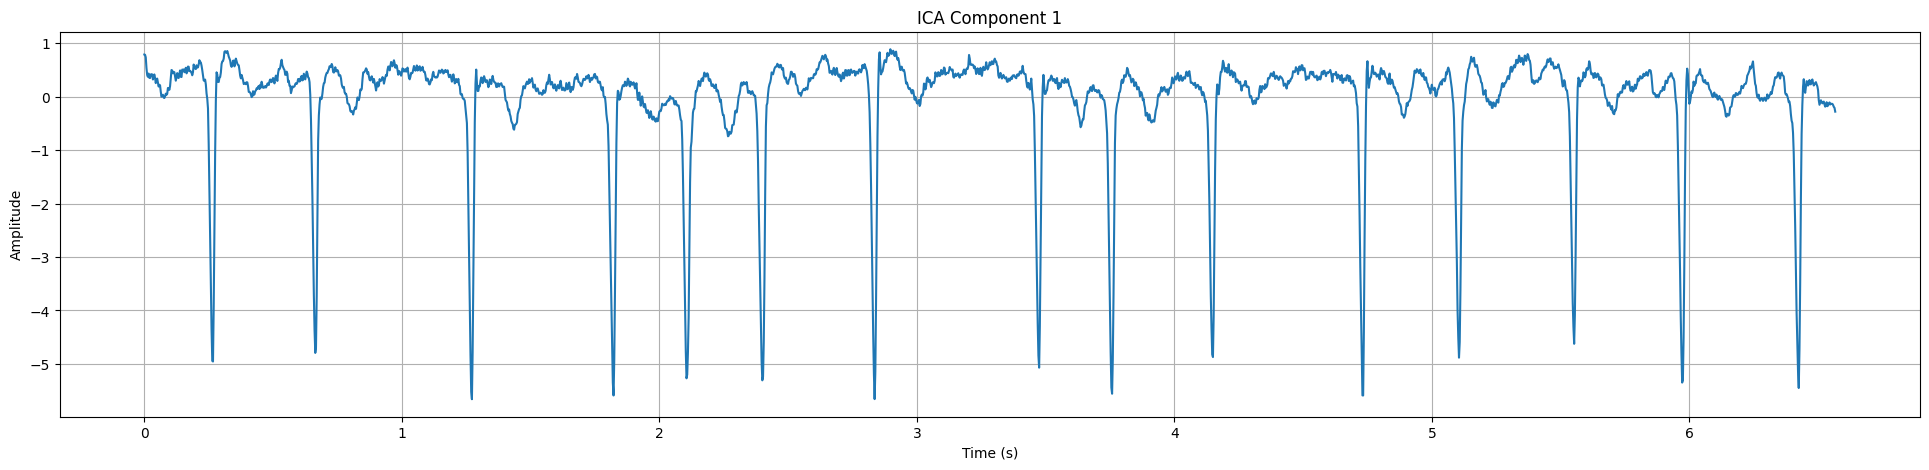

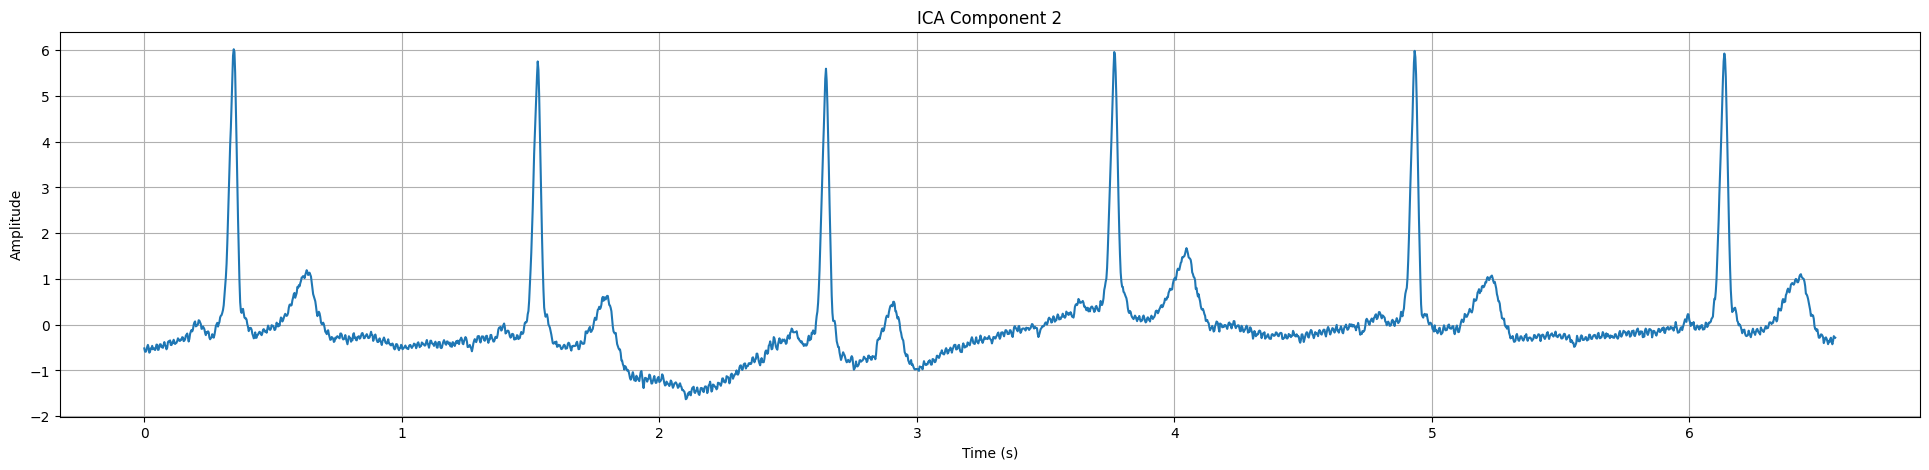

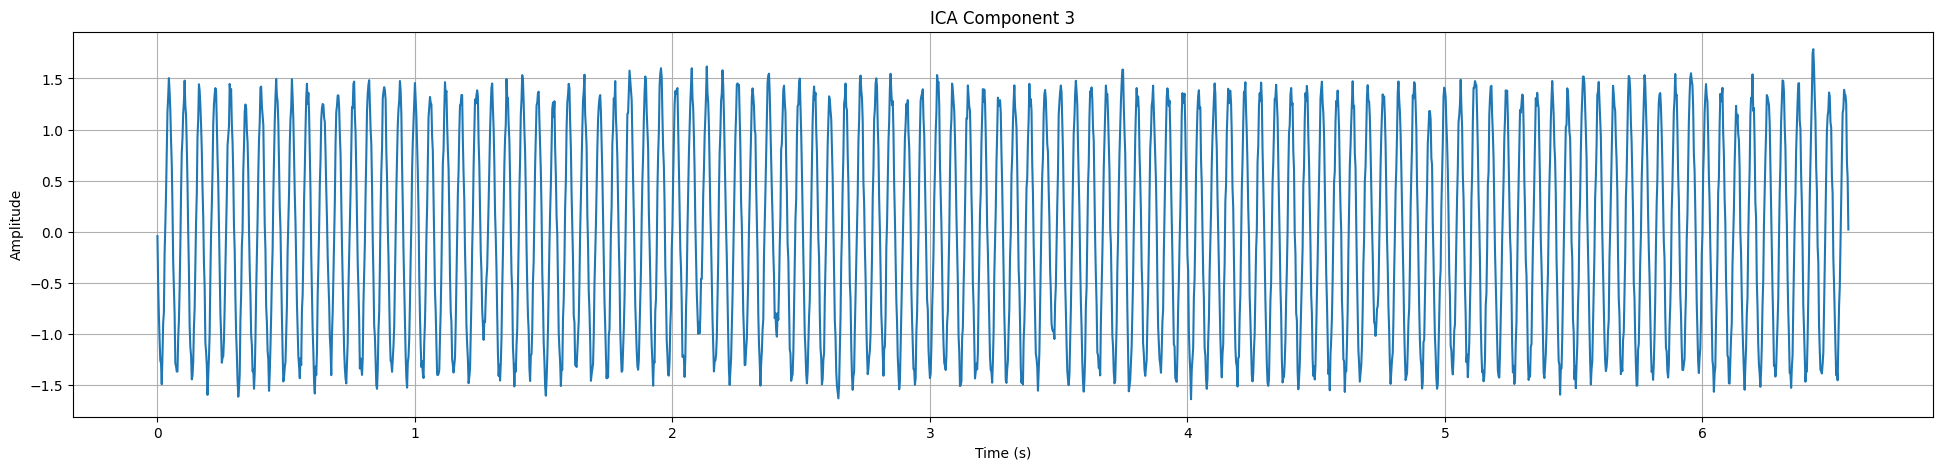

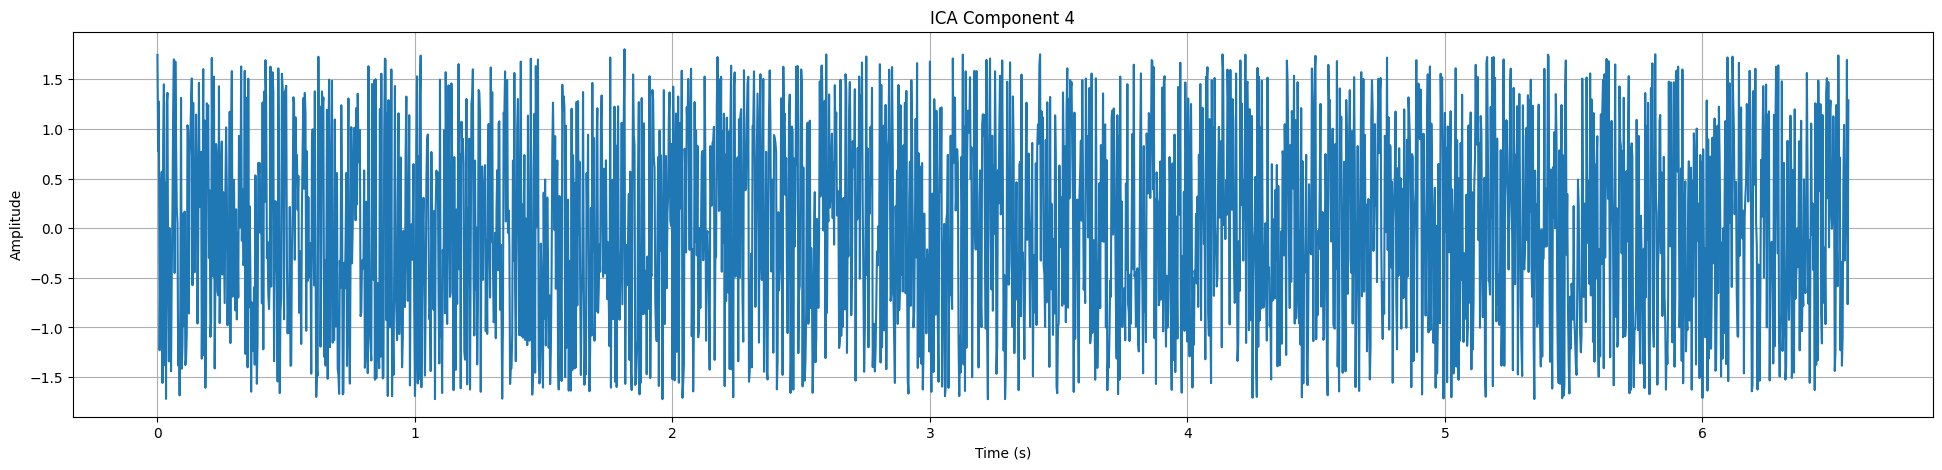

In [118]:
# apply ICA
ica = FastICA(n_components=4, random_state=42)
components = ica.fit_transform(signal_data.T)  # shape will be (n_samples, n_components)

# plot the ICA components
for i in range(4):
    component = components[:, i]

    plt.figure(figsize=(24, 5))
    plt.plot(np.arange(0, len(component) / sr, 1 / sr), component)
    plt.title(f"ICA Component {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
plt.show()

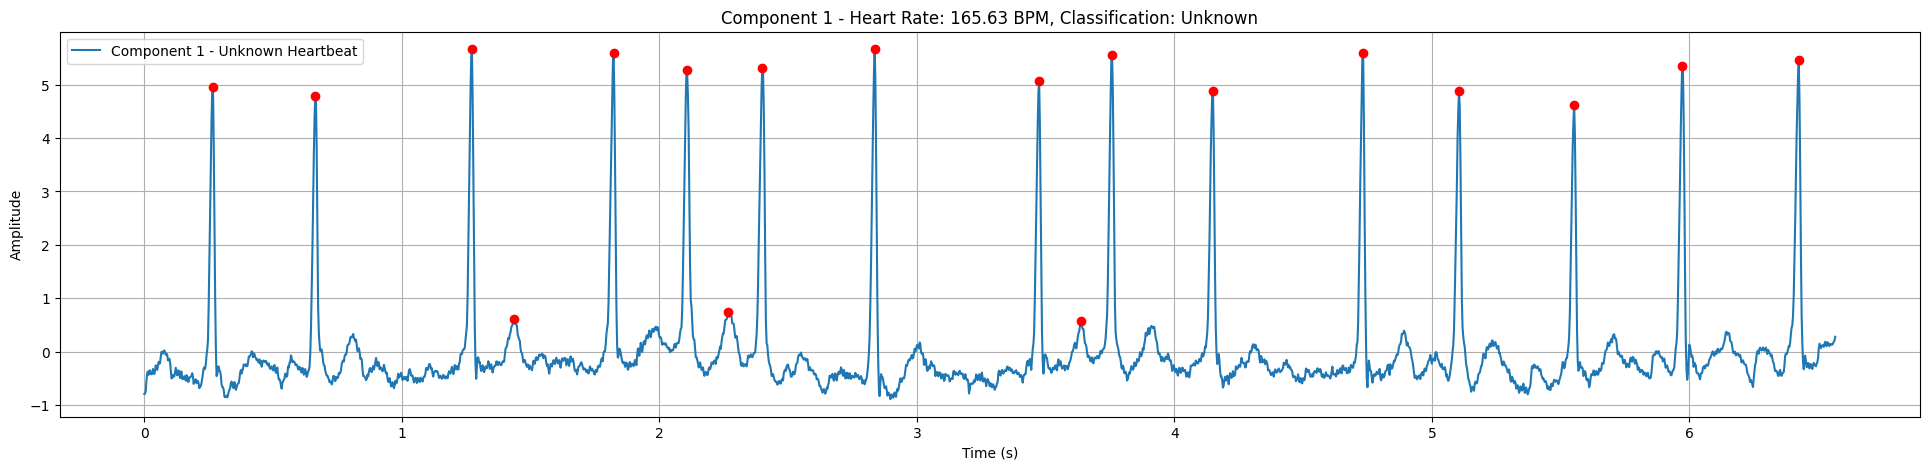

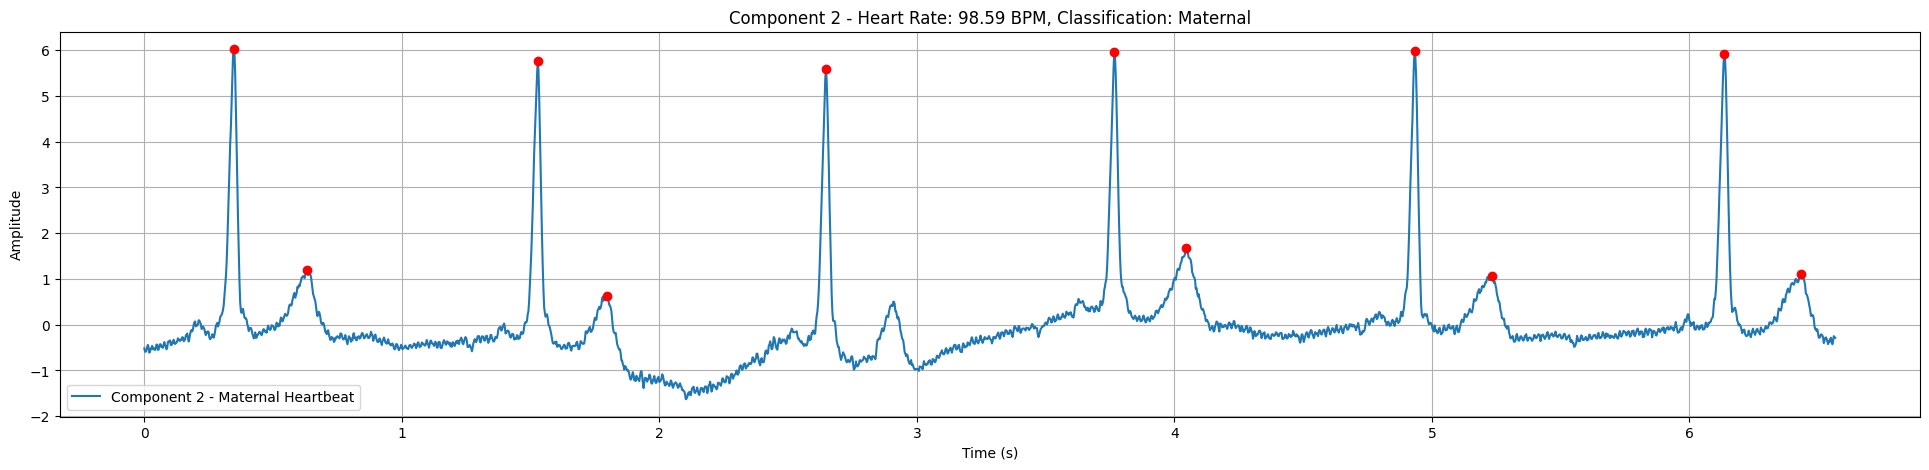

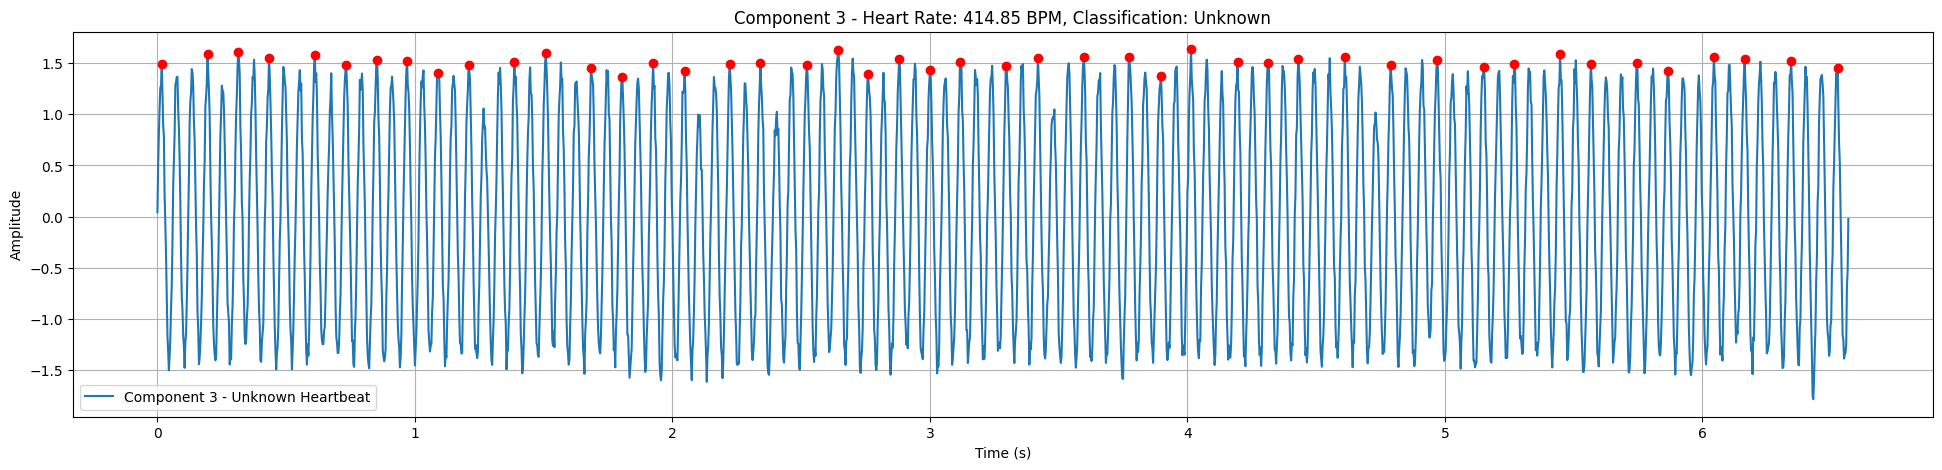

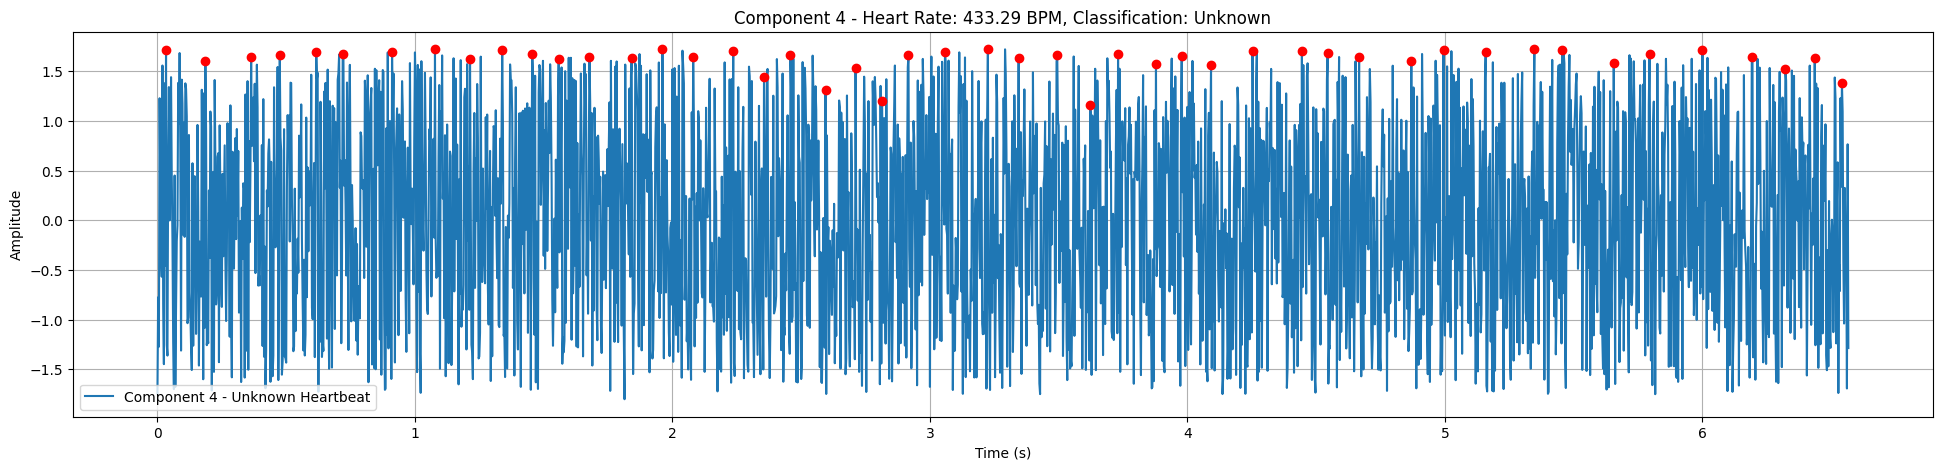

In [119]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def check_rotation(component, sr):
    distance = sr/10
    peaks, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _ , inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    # calculate average peak height for normal and inverted peaks to determine if signal is upside down or not
    avg_peak_height = np.mean(properties['peak_heights']) 
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights']) 

    # flip signal if inverted peaks are taller
    if avg_inv_peak_height > avg_peak_height:
        component = -component
        peaks, _ = find_peaks(component, distance=distance, height=0.1 * np.max(component))

    return peaks, component


def calculate_heartrate(component, sr):
    peaks, component = check_rotation(component, sr)
    
    peak_intervals = np.diff(peaks) / sr # calculate intervals between peaks in seconds
    heart_rate = 60 / np.mean(peak_intervals) # convert to bpm

    return heart_rate, peaks, component


def dominant_frequency(component, sr):
    freqs = fftfreq(len(component), 1 / sr)
    fft_vals = np.abs(fft(component))
    peak_freq = freqs[np.argmax(fft_vals)]
    return abs(peak_freq)


def analyze_components(components, sr, freq_min=0.5, freq_max=3):
    identified_heartbeats = []
    
    for i in range(4):
        component = components[:, i]
        classification = 'Unknown'

        heart_rate, peaks, component = calculate_heartrate(component, sr)
        
        # find frequency with highest amplitude in the FFT
        dom_freq = dominant_frequency(component, sr)
        
        # check if dominant frequency is within heart rate range (0.5-3Hz or 30-180bpm)
        if freq_min <= dom_freq <= freq_max:
            if 110 <= heart_rate <= 170:
                classification = 'Fetal'
            elif 60 <= heart_rate <= 100:
                classification = 'Maternal'    
            
            identified_heartbeats.append((i, heart_rate, dom_freq, classification))
        
        # plot component and peaks
        plt.figure(figsize=(24, 5))
        plt.plot(np.arange(0, len(component) / sr, 1 / sr), component, label=f'Component {i+1} - {classification} Heartbeat')
        plt.plot(peaks / sr, component[peaks], 'ro')
        plt.title(f"Component {i+1} - Heart Rate: {heart_rate:.2f} BPM, Classification: {classification}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

    plt.show()
    return identified_heartbeats

# analyze components
identified_heartbeats = analyze_components(components, sr)

In [120]:
# identify fetal and maternal heartbeats based on heart rate ranges
# maternal (60-100 bpm), fetal (110-160 bpm)

# heartpy ?